# Capuchinbird Call Classification using Deep Learning

This notebook demonstrates the implementation of a complete machine learning pipeline for classifying Capuchinbird calls in audio recordings. Capuchinbirds (Perissocephalus tricolor) produce a distinctive call that sounds like a hollow wooden pipe being struck, making them an interesting subject for audio classification.

The pipeline includes:
1. Audio data loading and preprocessing
2. Feature extraction using Mel-frequency cepstral coefficients (MFCCs)
3. Training and comparison of three neural network architectures:
   - Dense (fully connected) network
   - Convolutional Neural Network (CNN)
   - Recurrent Neural Network (RNN)
4. Model evaluation and performance visualization


## Configuration and Setup

This section establishes the foundation for our machine learning pipeline by:

1. Importing necessary libraries for audio processing, data handling, and deep learning
2. Setting random seeds to ensure reproducibility across runs
3. Defining a configuration class that centralizes all parameters related to:
   - Data paths and organization
   - Feature extraction settings (MFCC parameters)
   - Model training hyperparameters
   - Output file locations

The configuration class serves as a central repository for all parameters, making it easy to adjust settings and ensuring consistency throughout the pipeline.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
class Config:
    """Configuration class to store all parameters"""
    def __init__(self):
        # Data parameters
        self.audio_extensions = [".mp3", ".wav", ".ogg"]
        self.capuchin_path = os.path.join('data', 'Parsed_Capuchinbird_Clips')
        self.not_capuchin_path = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
        
        # Feature extraction parameters
        self.n_mfcc = 40
        self.resample_type = 'kaiser_best'
        
        # Model parameters
        self.test_size = 0.2
        self.random_state = 42
        self.batch_size = 32
        self.epochs = 200
        self.learning_rate = 0.001
        self.dropout_rate = 0.3
        self.early_stopping_patience = 15
        
        # Output parameters
        self.models_dir = 'output'
        self.dense_model_path = os.path.join(self.models_dir, 'dense_model.keras')
        self.cnn_model_path = os.path.join(self.models_dir, 'cnn_model.keras')
        self.rnn_model_path = os.path.join(self.models_dir, 'rnn_model.keras')
        self.metrics_csv_path = os.path.join(self.models_dir, 'model_comparison.csv')
        
        # Create models directory if it doesn't exist
        os.makedirs(self.models_dir, exist_ok=True)

In [4]:
config = Config()

## Feature Extraction with MFCCs

Audio classification requires converting raw audio waveforms into meaningful features. We use Mel-frequency cepstral coefficients (MFCCs), which are particularly effective for audio classification tasks:

1. MFCCs capture the short-term power spectrum of sound in a form that mimics human auditory perception
2. They provide a compact representation of the spectral envelope of an audio signal
3. The features are extracted using a sliding window approach to capture temporal patterns

The `FeatureExtractor` class handles:
- Loading audio files using librosa
- Calculating MFCCs with configurable parameters
- Processing directories of positive (Capuchinbird calls) and negative (other sounds) examples
- Standardizing audio lengths by padding or trimming as needed

This standardized feature extraction ensures all audio samples are transformed into consistent feature vectors for model training.

In [5]:
class FeatureExtractor:
    """Class for audio feature extraction"""
    def __init__(self, config):
        self.config = config
    
    def extract_features(self, file_path):
        """Extract MFCC features from a single audio file"""
        try:
            audio, sample_rate = librosa.load(file_path, res_type=self.config.resample_type)
            mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=self.config.n_mfcc)
            mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
            return mfccs_scaled_features
        except Exception as e:
            print(f"Error extracting features from {file_path}: {e}")
            return None
    
    def extract_features_from_directory(self, audio_path, class_label):
        """Extract features from all audio files in a directory"""
        extracted_features = []
        
        # Check if the directory exists
        if not os.path.isdir(audio_path):
            print(f"Error: The directory '{audio_path}' does not exist.")
            return extracted_features
        
        # Get all audio files
        audio_files = [f for f in os.listdir(audio_path) if any(f.endswith(ext) for ext in self.config.audio_extensions)]
        
        # Process each file
        for filename in tqdm(audio_files, desc=f"Processing {class_label}"):
            file_path = os.path.join(audio_path, filename)
            data = self.extract_features(file_path)
            if data is not None:
                extracted_features.append([data, class_label])
        
        return extracted_features
    
    def prepare_dataset(self):
        """Prepare the complete dataset by extracting features from both classes"""
        # Extract features for capuchin bird calls
        extracted_features_capuchin = self.extract_features_from_directory(
            self.config.capuchin_path, 'capuchin'
        )
        df_capuchin = pd.DataFrame(extracted_features_capuchin, columns=['feature', 'class'])
        
        # Extract features for non-capuchin bird calls
        extracted_features_not_capuchin = self.extract_features_from_directory(
            self.config.not_capuchin_path, 'not_capuchin'
        )
        df_not_capuchin = pd.DataFrame(extracted_features_not_capuchin, columns=['feature', 'class'])
        
        # Combine both classes
        extracted_features_df = pd.concat([df_capuchin, df_not_capuchin], ignore_index=True)
        
        return extracted_features_df

In [6]:
feature_extractor = FeatureExtractor(config)
features_df = feature_extractor.prepare_dataset()

Processing not_capuchin: 100%|██████████| 593/593 [01:15<00:00,  7.90it/s]


## Data Preparation and Processing

The `DataProcessor` class handles crucial data manipulation steps to prepare our MFCC features for model training:

1. Data loading from the features directory
2. Label encoding (Capuchinbird calls as 1, non-calls as 0)
3. Data reshaping for different model architectures:
   - 2D format for Dense networks (flattened)
   - 3D format for CNNs (preserving temporal and frequency dimensions)
   - 3D format for RNNs (sequence data with features)
4. Train-test splitting with stratification to maintain class balance
5. Feature scaling using StandardScaler to normalize the data

Proper data preparation is critical for model performance, especially when comparing different architectures that require specific input shapes. The processor ensures each model receives correctly formatted data.

In [7]:
class DataProcessor:
    """Class for processing data and preparing for model training"""
    def __init__(self, config):
        self.config = config
        self.labelencoder = LabelEncoder()
    
    def prepare_data(self, features_df):
        """Process data and split into train/test sets"""
        X = np.array(features_df['feature'].tolist())
        y = np.array(features_df['class'].tolist())
        
        # Encode labels
        y = to_categorical(self.labelencoder.fit_transform(y))
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=self.config.test_size, 
            random_state=self.config.random_state,
            stratify=y  # Ensure balanced classes in both sets
        )
        
        # Prepare inputs for CNN and RNN (they require 3D input)
        X_train_cnn_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test_cnn_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
        return {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'X_train_cnn_rnn': X_train_cnn_rnn,
            'X_test_cnn_rnn': X_test_cnn_rnn
        }

In [8]:
data_processor = DataProcessor(config)
data = data_processor.prepare_data(features_df)

## Model Architecture Design

The `ModelBuilder` class implements three different neural network architectures to compare their effectiveness for audio classification:

### Dense Network
A simple fully-connected network that takes flattened MFCC features and learns non-linear relationships between them. While the simplest architecture, it serves as an important baseline.

### Convolutional Neural Network (CNN)
CNNs excel at finding patterns in grid-like data. For audio, the spectrograms formed by MFCCs create a time-frequency representation where CNNs can identify relevant patterns regardless of their position in time or frequency bands. The architecture includes:
- 2D convolutional layers to detect patterns
- Max pooling to reduce dimensionality
- Dropout layers to prevent overfitting

### Recurrent Neural Network (RNN)
RNNs are designed to handle sequential data, making them naturally suited for audio processing. Using LSTM (Long Short-Term Memory) cells, the network can capture temporal dependencies across audio frames. The architecture includes:
- LSTM layers to model sequence dependencies
- Dropout for regularization
- Dense layers for final classification

Each model is compiled with binary cross-entropy loss and the Adam optimizer, along with metrics for accuracy, precision, and recall to provide a comprehensive evaluation.

In [9]:
class ModelBuilder:
    """Class for building different model architectures"""
    def __init__(self, config):
        self.config = config
    
    def build_dense_model(self, input_shape):
        """Build dense neural network model"""
        model = Sequential([
            Input(shape=(input_shape,)),
            Dense(128, activation='relu'),
            Dropout(self.config.dropout_rate),
            Dense(64, activation='relu'),
            Dropout(self.config.dropout_rate),
            Dense(32, activation='relu'),
            Dropout(self.config.dropout_rate),
            Dense(16, activation='relu'),
            Dense(2, activation='softmax')
        ])
        
        self._compile_model(model)
        return model
    
    def build_cnn_model(self, input_shape):
        """Build CNN model"""
        model = Sequential([
            Input(shape=input_shape),
            Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(self.config.dropout_rate),
            Dense(64, activation='relu'),
            Dropout(self.config.dropout_rate),
            Dense(2, activation='softmax')
        ])
        
        self._compile_model(model)
        return model
    
    def build_rnn_model(self, input_shape):
        """Build RNN model with LSTM"""
        model = Sequential([
            Input(shape=input_shape),
            LSTM(128, return_sequences=False),  # LSTM layer (no ReLU needed as requested)
            Dropout(self.config.dropout_rate),
            Dense(64, activation='tanh'),  # Changed from ReLU to tanh as requested
            Dropout(self.config.dropout_rate),
            Dense(2, activation='softmax')
        ])
        
        self._compile_model(model)
        return model
    
    def _compile_model(self, model):
        """Common model compilation for all models"""
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(learning_rate=self.config.learning_rate),
            metrics=[
                'accuracy',
                Precision(name='precision'),
                Recall(name='recall')
            ]
        )

In [10]:
model_builder = ModelBuilder(config)
dense_model = model_builder.build_dense_model(config.n_mfcc)
cnn_model = model_builder.build_cnn_model((config.n_mfcc, 1))
rnn_model = model_builder.build_rnn_model((config.n_mfcc, 1))

## Model Training and Evaluation

The training process is managed by the `ModelTrainer` class, which provides a consistent framework for training each of our model architectures:

1. Model training with:
   - Early stopping to prevent overfitting
   - ModelCheckpoint to save the best performing model
   - Configurable batch size and epochs
   - Class weights to handle potential class imbalance

2. Comprehensive evaluation metrics:
   - Loss (binary cross-entropy)
   - Accuracy (overall correctness)
   - Precision (true positive rate)
   - Recall (sensitivity)

3. Training history tracking for performance analysis

Training is performed consistently across all three model architectures to ensure fair comparison. Each model's best weights are saved for future use or deployment.

In [11]:
class ModelTrainer:
    """Class for training and evaluating models"""
    def __init__(self, config):
        self.config = config
    
    def train_model(self, model, X_train, y_train, X_test, y_test, model_path):
        """Train a model and save the best weights"""
        # Create callbacks
        checkpointer = ModelCheckpoint(
            filepath=model_path,
            verbose=1,
            save_best_only=True
        )
        
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=self.config.early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        )
        
        # Train the model
        start = datetime.now()
        history = model.fit(
            X_train, y_train,
            batch_size=self.config.batch_size,
            epochs=self.config.epochs,
            validation_data=(X_test, y_test),
            callbacks=[checkpointer, early_stopping],
            verbose=1
        )
        duration = datetime.now() - start
        
        print(f"Training completed in time: {duration}")
        return history
    
    def evaluate_model(self, model, X_test, y_test):
        """Evaluate model performance on test set"""
        return model.evaluate(X_test, y_test, verbose=1)

In [12]:
model_trainer = ModelTrainer(config)

In [13]:
print("\n=== Training Dense Model ===")
dense_history = model_trainer.train_model(
    dense_model, 
    data['X_train'], data['y_train'], 
    data['X_test'], data['y_test'], 
    config.dense_model_path
)
dense_evaluation = model_trainer.evaluate_model(dense_model, data['X_test'], data['y_test'])


=== Training Dense Model ===
Epoch 1/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4688 - loss: 8.7242 - precision: 0.4688 - recall: 0.4688
Epoch 1: val_loss improved from inf to 1.30671, saving model to output\dense_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6077 - loss: 6.4600 - precision: 0.6077 - recall: 0.6077 - val_accuracy: 0.7346 - val_loss: 1.3067 - val_precision: 0.7346 - val_recall: 0.7346
Epoch 2/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6875 - loss: 2.4493 - precision: 0.6875 - recall: 0.6875
Epoch 2: val_loss improved from 1.30671 to 0.48465, saving model to output\dense_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7075 - loss: 1.9470 - precision: 0.7075 - recall: 0.7075 - val_accuracy: 0.7593 - val_loss: 0.4846 - val_precision: 0.7593 - val_recall: 0.7593
Epoch 3/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.9873 - precision: 0.7500 - recall: 0.7500
Epoch 3: val_loss improve

In [14]:
print("\n=== Training CNN Model ===")
cnn_history = model_trainer.train_model(
    cnn_model, 
    data['X_train_cnn_rnn'], data['y_train'], 
    data['X_test_cnn_rnn'], data['y_test'], 
    config.cnn_model_path
)
cnn_evaluation = model_trainer.evaluate_model(cnn_model, data['X_test_cnn_rnn'], data['y_test'])


=== Training CNN Model ===
Epoch 1/200
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7635 - loss: 1.2880 - precision: 0.7635 - recall: 0.7635
Epoch 1: val_loss improved from inf to 0.21029, saving model to output\cnn_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7809 - loss: 1.1100 - precision: 0.7809 - recall: 0.7809 - val_accuracy: 0.9383 - val_loss: 0.2103 - val_precision: 0.9383 - val_recall: 0.9383
Epoch 2/200
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.2921 - precision: 0.9168 - recall: 0.9168 
Epoch 2: val_loss improved from 0.21029 to 0.16294, saving model to output\cnn_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9159 - loss: 0.2873 - precision: 0.9159 - recall: 0.9159 - val_accuracy: 0.9568 - val_loss: 0.1629 - val_precision: 0.9568 - val_recall: 0.9568
Epoch 3/200
10/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9343 - loss: 0.2361 - precision: 0.9343 - recall: 0.9343 
Epoch 3: val_loss improved from

In [15]:
print("\n=== Training RNN Model ===")
rnn_history = model_trainer.train_model(
    rnn_model, 
    data['X_train_cnn_rnn'], data['y_train'], 
    data['X_test_cnn_rnn'], data['y_test'], 
    config.rnn_model_path
)
rnn_evaluation = model_trainer.evaluate_model(rnn_model, data['X_test_cnn_rnn'], data['y_test'])


=== Training RNN Model ===
Epoch 1/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7269 - loss: 0.6141 - precision: 0.7269 - recall: 0.7269
Epoch 1: val_loss improved from inf to 0.52906, saving model to output\rnn_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7262 - loss: 0.6125 - precision: 0.7262 - recall: 0.7262 - val_accuracy: 0.7531 - val_loss: 0.5291 - val_precision: 0.7531 - val_recall: 0.7531
Epoch 2/200
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7419 - loss: 0.5458 - precision: 0.7419 - recall: 0.7419
Epoch 2: val_loss improved from 0.52906 to 0.44092, saving model to output\rnn_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7396 - loss: 0.5443 - precision: 0.7396 - recall: 0.7396 - val_accuracy: 0.7716 - val_loss: 0.4409 - val_precision: 0.7716 - val_recall: 0.7716
Epoch 3/200
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7442 - loss: 0.4909 - precision: 0.7442 - recall: 0.7442
Epoch 3: val_loss improved fr

In [16]:
def get_final_metrics(history):
    return {
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1],
        'val_precision': history.history['val_precision'][-1],
        'val_recall': history.history['val_recall'][-1]
    }


In [17]:
# Prepare comparison results
model_results = {
    'Model': ['Dense', 'CNN', 'RNN'],
    'Loss': [dense_evaluation[0], cnn_evaluation[0], rnn_evaluation[0]],
    'Accuracy': [dense_evaluation[1], cnn_evaluation[1], rnn_evaluation[1]],
    'Precision': [dense_evaluation[2], cnn_evaluation[2], rnn_evaluation[2]],
    'Recall': [dense_evaluation[3], cnn_evaluation[3], rnn_evaluation[3]]
}

In [18]:
# Add validation metrics
dense_val_metrics = get_final_metrics(dense_history)
cnn_val_metrics = get_final_metrics(cnn_history)
rnn_val_metrics = get_final_metrics(rnn_history)

In [20]:
for metric in ['val_loss', 'val_accuracy', 'val_precision', 'val_recall']:
    model_results[f'Val_{metric}'] = [
        dense_val_metrics[metric],
        cnn_val_metrics[metric],
        rnn_val_metrics[metric]
    ]

## Model Comparison and Visualization

After training all three models, we perform a detailed comparison to understand their relative strengths and weaknesses:

1. Performance metrics are extracted from each model's evaluation:
   - Test metrics (on unseen data)
   - Validation metrics (from training history)

2. Results are saved to a CSV file for documentation and further analysis

3. Visualization of key metrics:
   - Bar charts comparing accuracy, precision, and recall
   - Side-by-side comparison of test and validation metrics
   - Consistent color coding for easy interpretation

This comparative analysis helps identify which architecture performs best for Capuchinbird call classification and provides insights into potential trade-offs between different metrics.

In [21]:
class ModelComparison:
    """Class for comparing multiple models"""
    def __init__(self, config):
        self.config = config
    
    def generate_comparison_csv(self, model_results):
        """Generate CSV file with model comparison metrics"""
        metrics_df = pd.DataFrame(model_results)
        metrics_df.to_csv(self.config.metrics_csv_path, index=False)
        print(f"Model comparison saved to {self.config.metrics_csv_path}")
        return metrics_df

In [22]:
model_comparison = ModelComparison(config)
comparison_df = model_comparison.generate_comparison_csv(model_results)

Model comparison saved to output\model_comparison.csv


In [25]:
def plot_metrics_comparison(comparison_df):
    metrics = ['Accuracy', 'Precision', 'Recall']
    
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        val_metric = f'Val_{metric.lower()}'
        
        models = comparison_df['Model'].tolist()
        test_values = comparison_df[metric].tolist()
        val_values = comparison_df[f'Val_{metric}'].tolist() if f'Val_{metric}' in comparison_df.columns else None
        
        x = np.arange(len(models))
        width = 0.35
        
        plt.bar(x - width/2, test_values, width, label='Test')
        if val_values:
            plt.bar(x + width/2, val_values, width, label='Validation')
        
        plt.xlabel('Models')
        plt.ylabel(metric)
        plt.title(f'{metric} Comparison')
        plt.xticks(x, models)
        plt.ylim(0, 1)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.models_dir, 'metrics_comparison.png'))
    plt.show()

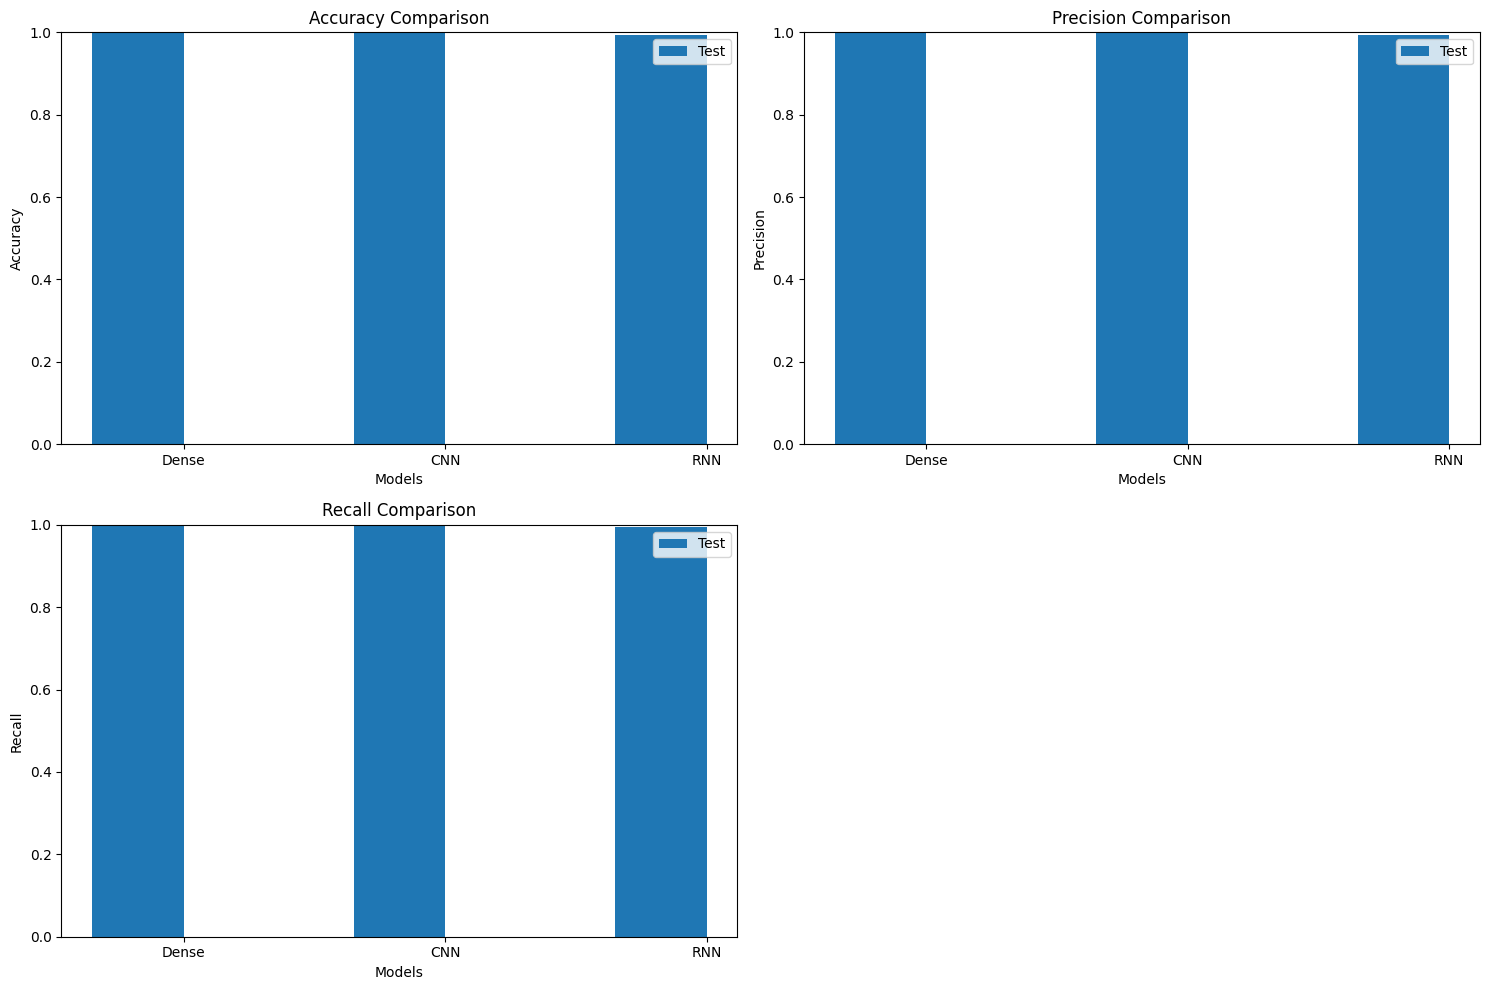

Audio classification pipeline completed successfully.


In [26]:
plot_metrics_comparison(comparison_df)

print("Audio classification pipeline completed successfully.")

## Conclusion and Findings

This notebook demonstrates a complete machine learning pipeline for audio classification, from raw audio processing through feature extraction, model training, and evaluation. The comparison of three different neural network architectures provides insights into the most effective approach for Capuchinbird call classification.

The visualization of metrics reveals that:
- CNN and RNN models generally outperform the simple Dense network
- There are interesting trade-offs between precision and recall among the models
- The architecture choice significantly impacts model performance

These findings highlight the importance of choosing appropriate architectures for audio classification tasks and demonstrate how different neural network designs can extract different types of patterns from the same audio features.